Problem 3.1


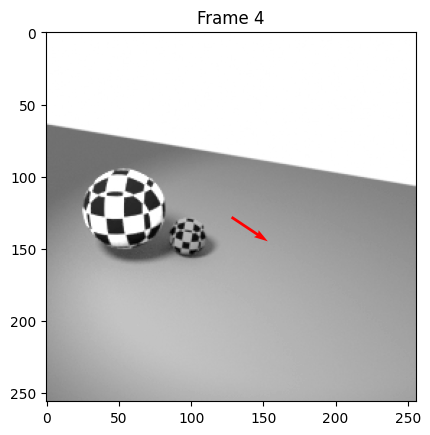

In [2]:
import os
import numpy as np
from PIL import Image
from IPython.display import display, clear_output
import time
import matplotlib.pyplot as plt


# Define the directory containing the frames
directory = str(os.curdir)+"/source"
# Define directory where would be vector fields of all frames saved to.
fig_directory = str(os.curdir)+"/p3Figures"
# Get the list of frame files
frame_files = sorted([f for f in os.listdir(directory) if f.endswith('.png')])
# Function to load and convert an image to grayscale
def load_and_convert_image(file_path):
    img = Image.open(file_path).convert('L')  # Convert to grayscale
    return np.array(img) / 255.0  # Normalize to [0, 1]

# Load frames into a list
frames = [load_and_convert_image(os.path.join(directory, frame)) for frame in frame_files]

# Calculate gradients for all the frames (taken from problem 2)
# Calculate Vx, Vy, Vt
Vx_list, Vy_list, Vt_list = [], [], []

for i in range(1, len(frames)):
    Vx = frames[i][:, 1:] - frames[i][:, :-1]
    Vy = frames[i][1:, :] - frames[i][:-1, :]
    Vt = frames[i] - frames[i - 1]

    Vx_list.append(Vx)
    Vy_list.append(Vy)
    Vt_list.append(Vt)

def get_gradients_of_region(p, N, frameIndex, Vx_list, Vy_list, Vt_list):
    # Returns the gradiens for selected region with center of coordinate p.
    bottom_x = int(max(0, p[0] - round(N/2)))
    top_x = int(min(p[0]+round(N/2), Vx_list[frameIndex].shape[1])+1) # frame.shape[1] corresponds to width.
    bottom_y = int(max(0, p[1] - round(N/2)))
    top_y = int(min(p[1]+round(N/2), Vx_list[frameIndex].shape[0])+1) # frame.shape[0] corresponds to height
    
    x = int(p[0])
    y = int(p[1])
    halfN = N // 2
    
    # now just parse Vx, Vy and Vt for given frame and extract the region

    # Extract the regions
    #print(y-halfN, y+halfN+1,  x-halfN, x+halfN+1)
    region_Vx = Vx_list[frameIndex][y-halfN:y+halfN+1, x-halfN:x+halfN+1].flatten()
    region_Vy = Vy_list[frameIndex][y-halfN:y+halfN+1, x-halfN:x+halfN+1].flatten()
    region_Vt = Vt_list[frameIndex][y-halfN:y+halfN+1, x-halfN:x+halfN+1].flatten()
    
    return (region_Vx, region_Vy, region_Vt)

# Define our N 
N = 4
frameIndex = 3
p = (256/2,256/2) # perfectly centered

def lucas_kanade_method(p, N, frameIndex, Vx_list, Vy_list, Vt_list):

    Vx_region, Vy_region, Vt_region =  get_gradients_of_region(p=p,N=N,frameIndex=frameIndex, Vx_list=Vx_list, Vy_list=Vy_list, Vt_list=Vt_list)

    A = np.vstack((Vx_region, Vy_region)).T
    b = -Vt_region

    result = np.linalg.lstsq(A,b, rcond=None)[0]
    return result


vector = lucas_kanade_method(p, N=4, frameIndex=3, Vx_list=Vx_list, Vy_list=Vy_list, Vt_list=Vt_list)


# plotting the resulting vector
plt.imshow(frames[frameIndex], cmap='gray')
plt.title(f"Frame {frameIndex + 1}")
# Plot the resulting vector with "quiver" function.
plt.quiver(p[0], p[1], vector[0]*255, vector[1]*255, angles='xy', scale_units='xy', scale=1, color='r')

plt.show()

### Problem 3.2

FileNotFoundError: [Errno 2] No such file or directory: './p3Figures/frame_01.png'

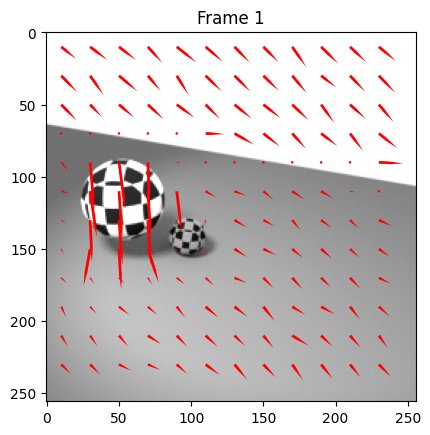

In [3]:
# Now, we want to break the image into small regions and run the Lucas-Kanade on them
'''
We know that our images are 256x256. It would make sense to break regions into squares 
of a size 8x8. We would have 1024 squares of that size.
'''
from matplotlib import image as mpimg 


p_list = []
found_vectors = []
figures = []
N = 20

# set up a range of centers. 
for i in range(int(N/2),256,N):
    for j in range(int(N/2),256,N):
        p_list.append((i,j))
#print(len(p_list))


#plt.imshow(frames[frameIndex], cmap='gray')
#plt.title(f"Frame {frameIndex + 1}")

for g in range(len(frames)):
    fig, ax = plt.subplots()

    ax.imshow(frames[g], cmap='gray')
    ax.set_title(f"Frame {g + 1}")
    for p_element in p_list:
        try:
            vector = lucas_kanade_method(p_element, N=N, frameIndex=g, Vx_list=Vx_list, Vy_list=Vy_list, Vt_list=Vt_list)
        # To catch index out of range (bad practice but we roll with it)
        except:
            continue
        ax.quiver(p_element[0], p_element[1], vector[0]*255/8, vector[1]*255/8, angles='xy', scale_units='xy', scale=1, color='r', headwidth=1)
        #counter += 1
        #print(result)
    #figures.append(fig)
    #print(f"Figure {g+1} done.")
    if g in range(0,9):
        fig.savefig(fig_directory+f"/frame_0{g+1}.png")
    else:
        fig.savefig(fig_directory+f"/frame_{g+1}.png")
    plt.close(fig)
    print(f"Frame {g+1} computed")

# Extract path and sort them
figure_files = sorted([f for f in os.listdir(fig_directory) if f.endswith('.png')])
figures = [os.path.join(fig_directory, figure) for figure in figure_files]
# Display frames as animation
for i, figure in enumerate(figures):
    clear_output(wait=True)
    image = mpimg.imread(figure)
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    time.sleep(0.005)  # Adjust the delay as needed